# Util

In [1]:
# !python -m pip install tensorflow keras
# !python -m pip install scikit-learn
# !python -m pip install nltk

In [2]:
# !pip install tensorflow==2.8.2

In [3]:
# !pip install --upgrade tensorflow scikeras keras

In [4]:
# import tensorflow as tf
# print("Version de TensorFlow:", tf.__version__)

# tf.config.list_physical_devices()

In [5]:
# import tensorflow as tf
# tf.config.experimental.list_physical_devices()
# tf.config.list_physical_devices()
# tf.test.gpu_device_name()

In [6]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Import

In [7]:
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import fasttext.util
import string
import json
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten,BatchNormalization,MaxPooling1D,SpatialDropout1D, Input, concatenate
from keras import regularizers
from keras import utils
from keras.callbacks import EarlyStopping
from keras.models import Model
import ast
from keras.utils.vis_utils import plot_model
import re
import os
import matplotlib.pyplot as plt
import pickle

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Coder le texte

## Récupération des textes et des années de publications (labels)

In [8]:
def GetDataBooks(chemin,df):
    # Récupérer la liste des noms de fichiers dans le dossier
    fichiers = os.listdir(chemin)
    
    # Initialiser une liste pour stocker les textes
    books = []

    # Initialiser une liste pour stocker les années extraites des noms de fichiers
    y = []
    correct_fichiers = []
    # Parcourir les fichiers et lire leur contenu
    for fichier in fichiers:
        chemin_fichier = os.path.join(chemin, fichier)
        with open(chemin_fichier, 'r', encoding='utf-8') as f:

            texte = f.read()

            # Extraire l'année du nom de fichier
            annee = re.search(r'\((\d{4})\)', fichier)  # Utilisation d'une expression régulière pour trouver l'année entre parenthèses
            
            # Si une année est trouvée, alors nous pouvons étudier le livre, nous l'ajoutons ainsi que son label dans les listes associées
            if annee:
                annee = int(annee.group(1)) # Récupérer l'année
                books.append(texte)   
                y.append(annee)  # Ajouter l'année extraite à la liste des labels
                correct_fichiers.append(fichier)
            else:
                print(f"Impossible de lire la date pour le fichier: {fichier}")
    fichiersframe = pd.DataFrame({'Filename': correct_fichiers})
    df['Filename'] = fichiersframe['Filename']
    yearframe = pd.DataFrame({'Year': y})
    df['Year'] = yearframe['Year']
    booksframe = pd.DataFrame({'Text': books})
    df['Text'] = booksframe['Text']

In [9]:
# Définition de la seed pour la reproductibilité des résultats
utils.set_random_seed(42)
df_train = pd.DataFrame()
df_val = pd.DataFrame()
df_test = pd.DataFrame()

# Chemin des dossier contenant les textes
dossier_train = 'train'
dossier_test = 'test'
dossier_val = 'validation'

GetDataBooks(dossier_train,df_train)
GetDataBooks(dossier_val,df_val)
GetDataBooks(dossier_test,df_test)
#pd.set_option('display.max_rows', None)
# display(df_train)
# display(df_val)
# display(df_test)

Impossible de lire la date pour le fichier: desktop.ini


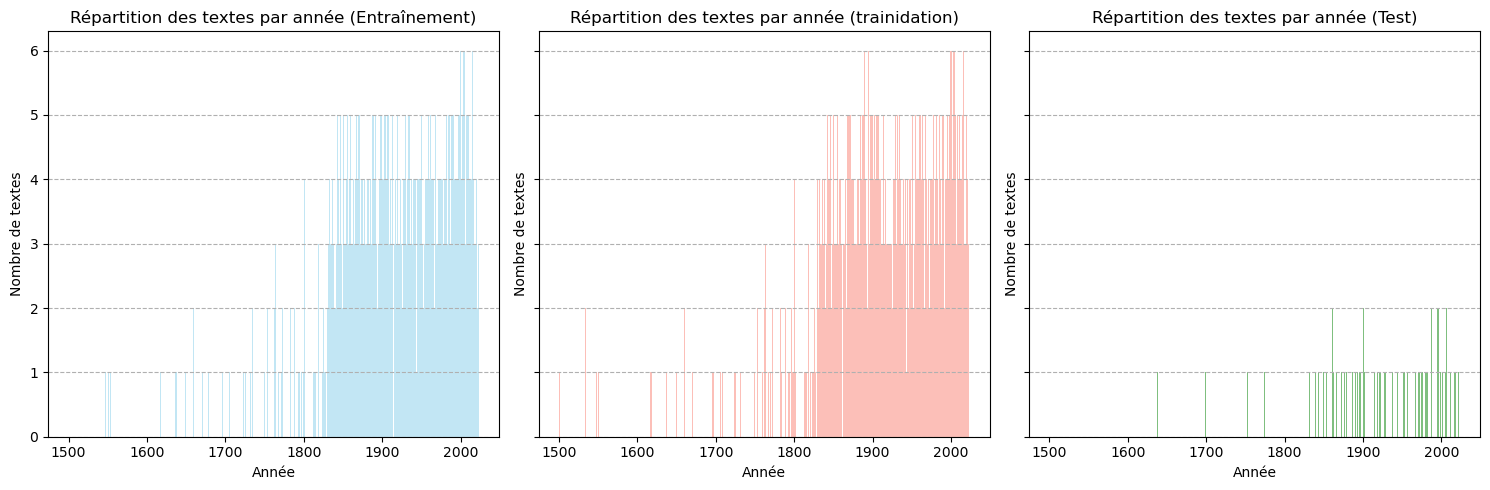

In [10]:
# Stocker les listes des valeurs 'Year'
train_years = df_train["Year"].tolist()
val_years = df_val["Year"].tolist()
test_years = df_test["Year"].tolist()

# Calculer la plage maximale des valeurs 'Year'
max_y = max(max(train_years), max(val_years), max(test_years))
min_y = min(min(train_years), min(train_years), min(test_years))

# Créer des sous-graphiques avec 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Tracer l'histogramme pour les données d'entraînement
axs[0].hist(train_years, bins=range(min_y, max_y + 1), alpha=0.5, color='skyblue')
axs[0].grid(axis='y', linestyle='--')
axs[0].set_xlabel('Année')
axs[0].set_ylabel('Nombre de textes')
axs[0].set_title('Répartition des textes par année (Entraînement)')

# Tracer l'histogramme pour les données de trainidation
axs[1].hist(train_years, bins=range(min_y, max_y + 1), alpha=0.5, color='salmon')
axs[1].grid(axis='y', linestyle='--')
axs[1].set_xlabel('Année')
axs[1].set_ylabel('Nombre de textes')
axs[1].set_title('Répartition des textes par année (trainidation)')

# Tracer l'histogramme pour les données de test
axs[2].hist(test_years, bins=range(min_y, max_y + 1), alpha=0.5, color='green')
axs[2].grid(axis='y', linestyle='--')
axs[2].set_xlabel('Année')
axs[2].set_ylabel('Nombre de textes')
axs[2].set_title('Répartition des textes par année (Test)')

# Ajuster la disposition pour éviter les chevauchements
plt.tight_layout()

# Afficher les graphiques
plt.show()

## Tokenization + Embedding + division en sequence

In [11]:
# Longueur maximale des séquences
max_len = 5000

### Classe Fonction et Variable

In [12]:
class WordTokenizer:
    def __init__(self, dict_word=None, dict_word_frequence=None):
        if dict_word is None:
            self.dict_word = {}
            self.word_freq = {}
            self.index = 1
        else:
            self.dict_word = dict_word
            self.index = len(dict_word) + 1
            self.word_freq = dict_word_frequence

    def fit(self, list_of_texts):
        # Si dict_word_frequence est None, initialiser word_freq
        if self.word_freq is None:
            self.word_freq = {}

        # Calculer la fréquence des mots
        for text in list_of_texts:
            tokens = word_tokenize(text)
            for token in tokens:
                if token in self.word_freq:
                    self.word_freq[token] += 1
                else:
                    self.word_freq[token] = 1

        # Trier les mots par fréquence dans l'ordre décroissant
        sorted_words = sorted(self.word_freq.items(), key=lambda x: x[1], reverse=True)

        # Attribuer des indices en fonction de la fréquence
        for _, (word, _) in enumerate(sorted_words):
            if word not in self.dict_word:
                self.dict_word[word] = self.index
                self.index += 1

        print("\nTokenization complete.")

    def get_local_word_freq(self, tokens):
        # Initialise un dictionnaire pour stocker la fréquence locale des mots
        local_word_freq = {}
        # Parcourt tous les tokens dans la liste
        for token in tokens:
            # Vérifie si le token n'est pas déjà présent dans le dictionnaire
            if token not in local_word_freq:
                # Si le token n'est pas présent, initialise sa fréquence à 1
                local_word_freq[token] = 1
            else:
                # Si le token est déjà présent, incrémente sa fréquence de 1
                local_word_freq[token] += 1
        sorted_words = sorted(local_word_freq.items(), key=lambda x: x[1], reverse=True)

        dict_local_word_freq = {}
        ind = 0
        # Attribuer des indices en fonction de la fréquence
        for _, (word, _) in enumerate(sorted_words):
            if word not in dict_local_word_freq:
                dict_local_word_freq[word] = ind
                ind += 1
                
        # Retourne le dictionnaire de fréquence locale des mots
        return dict_local_word_freq

    def tokenize(self, list_of_texts):
        total_texts = len(list_of_texts)
        # Initialise un tableau pour stocker les tokens de chaque texte
        token_arrays = np.empty((total_texts,), dtype=object)
        local_occs = np.empty((total_texts,), dtype=object)
        token_pos = np.empty((total_texts,), dtype=object)
        token_size = np.empty((total_texts,), dtype=object)
        # Parcourt chaque texte dans la liste
        for i, text in enumerate(list_of_texts):
            # Tokenise le texte en mots individuels
            tokens = word_tokenize(text)

            # Initialise un tableau pour stocker les informations sur chaque token
            token_array = np.empty((len(tokens), ), dtype=np.float32)
            local_occ = np.empty((len(tokens), ), dtype=np.float32)
            token_pos_arr = np.empty((len(tokens), ), dtype=np.float32)
            token_size_arr = np.empty((len(tokens), ), dtype=np.float32)
            # Calcule la fréquence locale des mots dans le texte
            local_word_freq = self.get_local_word_freq(tokens)

            position = 1
            # Parcourt chaque token dans le texte
            for j, token in enumerate(tokens):
                # Position du token
                if token == '.':
                    position = 0
                token_pos_arr[j] = position
                position +=1

                # Si le token est une ponctuation, on définit la taille à 0, sinon on prend la longueur du token
                if token in string.punctuation:
                    token_size_arr[j] = 0
                else:
                    token_size_arr[j] = len(token)

                # Vérifie si le token n'est pas dans le dictionnaire des mots
                if token not in self.dict_word:
                    token_array[j] = 0
                    local_occ[j] = local_word_freq[token]
                else:
                    token_array[j] = self.dict_word[token]
                    local_occ[j] = local_word_freq[token]
            
            token_arrays[i] = token_array
            local_occs[i] = local_occ
            token_pos[i] = token_pos_arr
            token_size[i] = token_size_arr

            percentage = (i + 1) / total_texts * 100
            print(f"Progression : {percentage:.2f}% complète")

        print("\nTokenisation terminée.")
        return token_arrays,local_occs, token_pos,token_size

In [13]:
from math import ceil

# Fonction pour diviser une liste en segments avec padding
def diviser_liste(liste, labels, taille):
    resultats = []
    res_labels = []
    nb_sequence_per_book = []
    ind = 0

    # Parcours de chaque sous-liste dans la liste principale
    for sous_liste in liste:
        longueur = len(sous_liste)
        if longueur < taille:
            padding = [0] * (taille - longueur) 
            sous_liste = np.concatenate((sous_liste, padding))
            longueur = taille

        nbtour = ceil(longueur / taille)
        lastpos = 0
        nb_sequence = 0
        # Division de la sous-liste en morceaux de taille spécifiée
        for i in range(nbtour):
            if lastpos + taille > longueur:
                if lastpos + taille - longueur > taille / 2:
                    break
                lastpos -= lastpos + taille - longueur

            # Ajout du morceau à la liste de résultats
            resultat = sous_liste[lastpos:lastpos + taille]
            lastpos += taille
            resultats.append(resultat)
            # A chaque fois que je divisie, jajoute le label au meme indice
            res_labels.append(labels[ind])
            nb_sequence += 1
        
        ind += 1
        nb_sequence_per_book.append(nb_sequence)

    # Convertir resultats et res_labels en tableaux numpy
    resultats = np.array(resultats)
    res_labels = np.array(res_labels)

    return resultats, res_labels, nb_sequence_per_book

# Fonction pour diviser une liste sans étiquettes
def diviser_liste2(liste,taille):
    resultats = []
    ind = 0
    # Parcours de chaque sous-liste dans la liste principale
    for sous_liste in liste:
        longueur = len(sous_liste)
        if longueur < taille:
            padding = [0] * (taille - longueur) 
            sous_liste = np.concatenate((sous_liste, padding))
            longueur = taille
        nbtour = ceil(longueur / taille)
        lastpos=0
        # Division de la sous-liste en morceaux de taille spécifiée
        for i in range(nbtour):
            if(lastpos + taille > longueur):
              if((lastpos + taille)-longueur > taille/2):
                  break
              lastpos -= (lastpos + taille)-longueur

            # Ajout du morceau à la liste de résultats
            resultat = sous_liste[lastpos:lastpos + taille]
            lastpos = lastpos + taille
            resultats.append(resultat)
        ind+=1

    # Convertir resultats et res_labels en tableaux numpy
    resultats = np.array(resultats)

    return resultats

### Création du tokenizer + sauvegarde du dictionnaire

In [14]:
# tokenizer = WordTokenizer()
# tokenizer.fit(df_train["Text"].to_list())
# tokenizer.fit(X_val)

In [15]:
# import json

# # Chemin du fichier de sauvegarde
# path_dict_word = "dict_word.json"
# path_dict_word_freq = "dict_word_freq.json"

# # Sauvegarde du dictionnaire en JSON dans un fichier
# with open(path_dict_word, "w") as json_file:
#     json.dump(tokenizer.dict_word, json_file)
# with open(path_dict_word_freq, "w") as json_file:
#     json.dump(tokenizer.word_freq, json_file)

### Récupération dico + Création du tokenizer 

In [16]:
import json

# Chemin du fichier JSON à lire
path_dict_word = "dict_word.json"
path_dict_word_freq = "dict_word_freq.json"

ditc_word = {}
word_freq = {}

# Lecture du fichier JSON
with open(path_dict_word, "r") as json_file:
    ditc_word = json.load(json_file)
with open(path_dict_word_freq, "r") as json_file:
    word_freq = json.load(json_file)
tokenizer = WordTokenizer(dict_word=ditc_word,dict_word_frequence=word_freq)

token_number = tokenizer.index

In [17]:
# Afficher les 100 premiers éléments
first_100 = {word: tokenizer.dict_word[word] for word in list(tokenizer.dict_word.keys())[:100]}
print(first_100)

{',': 1, '.': 2, 'de': 3, 'la': 4, 'et': 5, 'le': 6, 'à': 7, 'il': 8, 'l': 9, 'les': 10, 'un': 11, 'que': 12, 'd': 13, 'en': 14, 'je': 15, 'une': 16, 'elle': 17, 'des': 18, 'qui': 19, 'pas': 20, 'est': 21, 'qu': 22, 'ne': 23, 'dans': 24, '!': 25, 'se': 26, 'ce': 27, 'vous': 28, 'pour': 29, 'du': 30, 'n': 31, 's': 32, '?': 33, 'son': 34, 'était': 35, 'au': 36, 'lui': 37, 'plus': 38, 'avait': 39, 'mais': 40, ';': 41, 'a': 42, 'sur': 43, 'on': 44, ':': 45, 'c': 46, 'sa': 47, 'avec': 48, 'par': 49, 'nous': 50, 'j': 51, 'tout': 52, 'me': 53, 'comme': 54, 'ses': 55, 'si': 56, 'bien': 57, 'm': 58, 'y': 59, 'cette': 60, 'tu': 61, 'dit': 62, 'ils': 63, 'mon': 64, 'ai': 65, 'même': 66, 'sans': 67, 'moi': 68, 'être': 69, 'où': 70, 'ou': 71, 'fait': 72, 'deux': 73, 'aux': 74, 'là': 75, 'ces': 76, 'ma': 77, 'faire': 78, 'leur': 79, 't': 80, 'encore': 81, 'quand': 82, 'rien': 83, 'peu': 84, 'aussi': 85, 'tous': 86, 'autre': 87, 'homme': 88, 'ça': 89, 'peut': 90, 'sont': 91, 'temps': 92, 'non': 93, '

### Training Data

In [18]:
# # Transformation de chaque texte dans train en séquence
# sequences_trainA,sequences_trainB,sequences_trainC,sequences_trainD = tokenizer.tokenize(df_train["Text"].tolist())

In [19]:
# seqA = pd.DataFrame({'Sequence A': sequences_trainA})
# df_train['Sequence A'] = seqA['Sequence A']
# seqB = pd.DataFrame({'Sequence B': sequences_trainB})
# df_train['Sequence B'] = seqB['Sequence B']
# seqC = pd.DataFrame({'Sequence C': sequences_trainC})
# df_train['Sequence C'] = seqC['Sequence C']
# seqD = pd.DataFrame({'Sequence D': sequences_trainD})
# df_train['Sequence D'] = seqD['Sequence D']
# df_train['Form_Count'] = df_train['Sequence A'].apply(lambda seq: len(seq))
# # pd.set_option('display.max_rows', None)
# # display(df_train)

#### Save & Load

In [20]:
# # Save df
# with open('csv/df_train.pkl', 'wb') as f:
#     pickle.dump(df_train, f)

In [21]:
# Load df
with open('csv/df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)
    sequences_trainA = df_train["Sequence A"].to_list()
    sequences_trainB = df_train["Sequence B"].to_list()
    sequences_trainC = df_train["Sequence C"].to_list()
    sequences_trainD = df_train["Sequence D"].to_list()

#### Divide By Sequence

In [22]:
# Division des données en séquences de longueur maximale max_len
data_trainA,y_train,sequence_count_book_train = diviser_liste(sequences_trainA,df_train["Year"].to_list(), max_len)
data_trainB = diviser_liste2(sequences_trainB, max_len)
data_trainC = diviser_liste2(sequences_trainC, max_len)
data_trainD = diviser_liste2(sequences_trainD, max_len)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_trainA))

Nombre de séquences de données: 12216


### Validation Data

In [23]:
# sequences_valA,sequences_valB,sequences_valC,sequences_valD = tokenizer.tokenize(df_val["Text"].to_list())

In [24]:
# seqA = pd.DataFrame({'Sequence A': sequences_valA})
# df_val['Sequence A'] = seqA['Sequence A']
# seqB = pd.DataFrame({'Sequence B': sequences_valB})
# df_val['Sequence B'] = seqB['Sequence B']
# seqC = pd.DataFrame({'Sequence C': sequences_valC})
# df_val['Sequence C'] = seqC['Sequence C']
# seqD = pd.DataFrame({'Sequence D': sequences_valD})
# df_val['Sequence D'] = seqD['Sequence D']
# df_val['Form_Count'] = df_val['Sequence A'].apply(lambda seq: len(seq))
# # pd.set_option('display.max_rows', None)
# # display(df_val)

#### Save & Load

In [25]:
# # Save df
# with open('csv/df_val.pkl', 'wb') as f:
#     pickle.dump(df_val, f)

In [26]:
# Load df
with open('csv/df_val.pkl', 'rb') as f:
    df_val = pickle.load(f)
    sequences_valA = df_val["Sequence A"].to_list()
    sequences_valB = df_val["Sequence B"].to_list()
    sequences_valC = df_val["Sequence C"].to_list()
    sequences_valD = df_val["Sequence D"].to_list()

#### Divide By Sequence

In [27]:
# Division des données en séquences de longueur maximale max_len
data_valA,y_val,sequence_count_book_val = diviser_liste(sequences_valA,df_val["Year"].to_list(), max_len)
data_valB = diviser_liste2(sequences_valB, max_len)
data_valC =diviser_liste2(sequences_valC, max_len)
data_valD =diviser_liste2(sequences_valD, max_len)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_valA))

Nombre de séquences de données: 2520


### Test Data

In [28]:
# # Transformation de chaque texte dans test en séquence
# sequences_testA,sequences_testB,sequences_testC,sequences_testD = tokenizer.tokenize(df_test["Text"].to_list())

In [29]:
# seqA = pd.DataFrame({'Sequence A': sequences_testA})
# df_test['Sequence A'] = seqA['Sequence A']
# seqB = pd.DataFrame({'Sequence B': sequences_testB})
# df_test['Sequence B'] = seqB['Sequence B']
# seqC = pd.DataFrame({'Sequence C': sequences_testC})
# df_test['Sequence C'] = seqC['Sequence C']
# seqD = pd.DataFrame({'Sequence D': sequences_testD})
# df_test['Sequence D'] = seqD['Sequence D']
# df_test['Form_Count'] = df_test['Sequence A'].apply(lambda seq: len(seq))
# # pd.set_option('display.max_rows', None)
# # display(df_test)

#### Save & Load

In [30]:
# # Save df
# with open('csv/df_test.pkl', 'wb') as f:
#     pickle.dump(df_test, f)

In [31]:
# Load df
with open('csv/df_test.pkl', 'rb') as f:
    df_test = pickle.load(f)
    sequences_testA = df_test["Sequence A"].to_list()
    sequences_testB = df_test["Sequence B"].to_list()
    sequences_testC = df_test["Sequence C"].to_list()
    sequences_testD = df_test["Sequence D"].to_list()

#### Divide By Sequence

In [32]:
# Division des données en séquences de longueur maximale max_len
data_testA,y_test,sequence_count_book_test = diviser_liste(sequences_testA,df_test["Year"].to_list(), max_len)
data_testB = diviser_liste2(sequences_testB, max_len)
data_testC = diviser_liste2(sequences_testC, max_len)
data_testD = diviser_liste2(sequences_testD, max_len)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_testA))

Nombre de séquences de données: 1073


### Affichage informations

In [33]:
print("Nombre de séquences de données (Training):", len(data_trainA))
print("Nombre de séquences de données (Validation):", len(data_valA))
print("Nombre de séquences de données (Test):", len(data_testA))

Nombre de séquences de données (Training): 12216
Nombre de séquences de données (Validation): 2520
Nombre de séquences de données (Test): 1073


# Analyse des datas

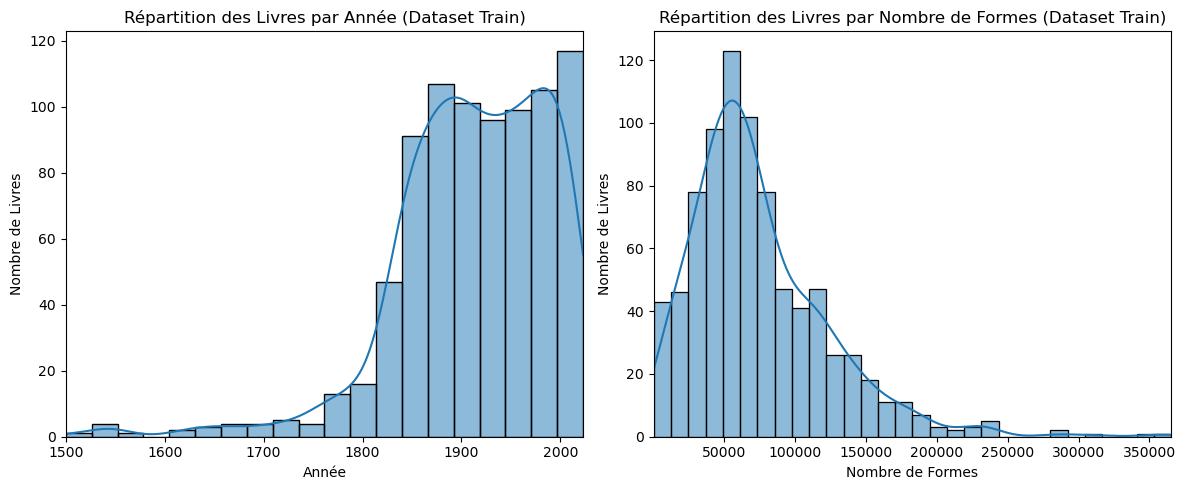

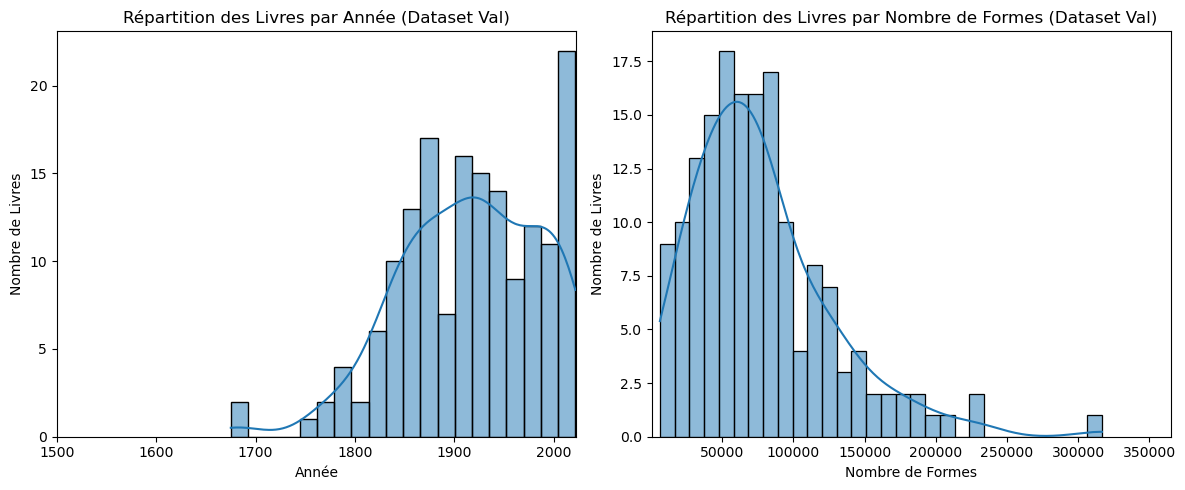

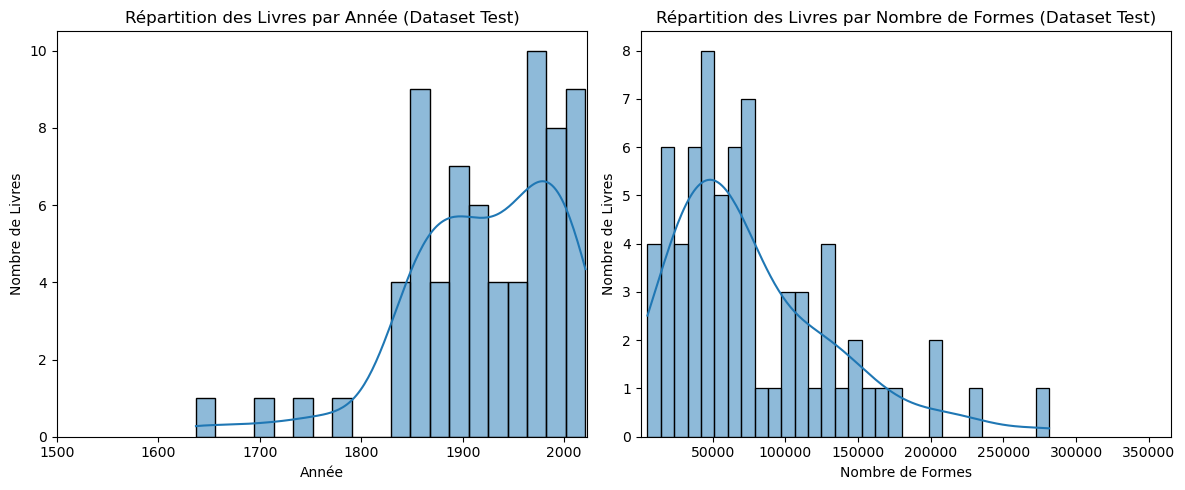

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenir les valeurs min et max pour 'Year' et 'Form_Count' dans les 3 datasets
min_year = min(df_train['Year'].min(), df_val['Year'].min(), df_test['Year'].min())
max_year = max(df_train['Year'].max(), df_val['Year'].max(), df_test['Year'].max())

min_form_count = min(df_train['Form_Count'].min(), df_val['Form_Count'].min(), df_test['Form_Count'].min())
max_form_count = max(df_train['Form_Count'].max(), df_val['Form_Count'].max(), df_test['Form_Count'].max())

# Fonction pour tracer les données avec échelle cohérente
def plot_data_infos(df, name_dataset, xlim_year, ylim_form_count):
    # Créer une figure avec deux sous-graphiques
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Premier sous-graphique : Répartition des Livres par Année
    sns.histplot(data=df, x='Year', bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f"Répartition des Livres par Année ({name_dataset})")
    axes[0].set_xlabel("Année")
    axes[0].set_ylabel("Nombre de Livres")
    axes[0].set_xlim(xlim_year)  # Définir la limite d'axe

    # Deuxième sous-graphique : Répartition des Livres par Nombre de Formes
    sns.histplot(data=df, x='Form_Count', bins=30, kde=True, ax=axes[1])
    axes[1].set_title(f"Répartition des Livres par Nombre de Formes ({name_dataset})")
    axes[1].set_xlabel("Nombre de Formes")
    axes[1].set_ylabel("Nombre de Livres")
    axes[1].set_xlim(ylim_form_count)  # Définir la limite d'axe

    # Ajuster les espacements entre les sous-graphiques
    plt.tight_layout()

    # Afficher les graphiques
    plt.show()

# Appeler la fonction pour chaque dataset avec le nom correspondant et les limites appropriées
plot_data_infos(df_train, "Dataset Train", (min_year, max_year), (min_form_count, max_form_count))
plot_data_infos(df_val, "Dataset Val", (min_year, max_year), (min_form_count, max_form_count))
plot_data_infos(df_test, "Dataset Test", (min_year, max_year), (min_form_count, max_form_count))


# Définition des architectures des modeles testés

In [205]:
def define_multi_model(max_len, vocab_size,model_params):

    inputA = Input(shape=(max_len,), name='input_tokens')  # Entrée pour les mots tokenisés
    inputB = Input(shape=(max_len,), name='input_word_freq')  # Entrée pour les fréquences des mots dans le texte
    inputC = Input(shape=(max_len,), name='input_word_pos')  # Entrée pour la position des mots
    inputD = Input(shape=(max_len,), name='input_word_size')  # Entrée pour la taille des mots


    # Branche A
    # Couche pour l'entrée des mots tokenisés
    x1 = Embedding(input_dim=vocab_size, output_dim=model_params['embedding_dim'], input_length=max_len, name='embedding_tokens_A')(inputA)
    for i in range(model_params['count_conv1D']):
        x1 = Conv1D(filters=model_params['conv1D_1_filters'][i], kernel_size=model_params['conv1D_1_kernel'], activation='relu', name='conv1d_A_'+str(i))(x1)
        if model_params['pool_size'] != 0:
            x1 = MaxPooling1D(pool_size=model_params['pool_size'], name='maxpooling_A_'+str(i))(x1)
    x1 = Flatten(name='flatten_A')(x1)
    x1 = Dropout(model_params['dropout'], name='dropout_A')(x1)
    x1 = Dense(model_params['dense_units_branch'], activation="relu", name='dense_A')(x1)

    # Branche A2
    # Couche pour l'entrée des mots tokenisés
    x2 = Embedding(input_dim=vocab_size, output_dim=model_params['embedding_dim'], input_length=max_len, name='embedding_tokens_A2')(inputA)
    for i in range(model_params['count_conv1D']):
        x2 = Conv1D(filters=model_params['conv1D_1_filters'][i], kernel_size=3, activation='relu', name='conv1d_A2_'+str(i))(x2)
        if model_params['pool_size'] != 0:
            x2 = MaxPooling1D(pool_size=model_params['pool_size'], name='maxpooling_A2_'+str(i))(x2)
    x2 = Flatten(name='flatten_A2')(x2)
    x2 = Dropout(model_params['dropout'], name='dropout_A2')(x2)
    x2 = Dense(model_params['dense_units_branch'], activation="relu", name='dense_A2')(x2)


    # Branche B
    # Couches pour l'entrée des fréquences de mots
    y1 = Embedding(input_dim=vocab_size, output_dim=model_params['embedding_dim'], input_length=max_len, name='embedding_tokens_B')(inputB)
    for i in range(model_params['count_conv1D']):
        y1 = Conv1D(filters=model_params['conv1D_1_filters'][i], kernel_size=model_params['conv1D_1_kernel'], activation='relu', name='conv1d_B_'+str(i))(y1)
        if model_params['pool_size'] != 0:
            y1 = MaxPooling1D(pool_size=model_params['pool_size'], name='maxpooling_B_'+str(i))(y1)
    y1 = Flatten(name='flatten_B')(y1)
    y1 = Dropout(model_params['dropout'], name='dropout_B')(y1)
    y1 = Dense(model_params['dense_units_branch'], activation="relu", name='dense_B')(y1)

    # Branche C
    # Couches pour l'entrée de la position des mots
    y2 = Embedding(input_dim=vocab_size, output_dim=model_params['embedding_dim'], input_length=max_len, name='embedding_tokens_C')(inputC)
    for i in range(model_params['count_conv1D']):
        y2 = Conv1D(filters=model_params['conv1D_1_filters'][i], kernel_size=model_params['conv1D_1_kernel'], activation='relu', name='conv1d_C_'+str(i))(y2)
        if model_params['pool_size'] != 0:
            y2 = MaxPooling1D(pool_size=model_params['pool_size'], name='maxpooling_C_'+str(i))(y2)
    y2 = Flatten(name='flatten_C')(y2)
    y2 = Dropout(model_params['dropout'], name='dropout_C')(y2)
    y2 = Dense(model_params['dense_units_branch'], activation="relu", name='dense_C')(y2)

    # Branche D
    # Couches pour l'entrée de la taille des mots
    y3 = Embedding(input_dim=vocab_size, output_dim=model_params['embedding_dim'], input_length=max_len, name='embedding_tokens_D')(inputD)
    for i in range(model_params['count_conv1D']):
        y3 = Conv1D(filters=model_params['conv1D_1_filters'][i], kernel_size=model_params['conv1D_1_kernel'], activation='relu', name='conv1d_D_'+str(i))(y3)
        if model_params['pool_size'] != 0:
            y3 = MaxPooling1D(pool_size=model_params['pool_size'], name='maxpooling_D_'+str(i))(y3)
    y3 = Flatten(name='flatten_D')(y3)
    y3 = Dropout(model_params['dropout'], name='dropout_D')(y3)
    y3 = Dense(model_params['dense_units_branch'], activation="relu", name='dense_D')(y3)
    
    branches = []
    if 'A' in model_params['included_branches']:
        branches.append(x1)
    if 'A2' in model_params['included_branches']:
        branches.append(x2)
    if 'B' in model_params['included_branches']:
        branches.append(y1)
    if 'C' in model_params['included_branches']:
        branches.append(y2)
    if 'D' in model_params['included_branches']:
        branches.append(y3)

    # Concaténer les sorties de toutes les branches
    combined = concatenate(branches, name='concatenated_features')

    # Couches denses pour les sorties combinées
    z = Dense(model_params['dense_units'], activation="relu", name='dense_combined')(combined)
    z = Dense(1, activation="linear", name='output')(z)

    # Combinez les entrées et les sorties en un modèle
    model = Model(inputs=[inputA, inputB, inputC, inputD], outputs=z)
    
    return model

In [206]:
# from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, concatenate
# from keras.models import Model

# def create_branch(input_layer, vocab_size, model_params, branch_name):
#     # Crée une couche d'Embedding
#     x = Embedding(input_dim=vocab_size, output_dim=model_params['embedding_dim'], input_length=max_len, name=f'embedding_{branch_name}')(input_layer)

#     # Applique une série de couches Conv1D, suivies de MaxPooling1D si nécessaire
#     for i in range(model_params['count_conv1D']):
#         x = Conv1D(filters=model_params['conv1D_1_filters'][i], kernel_size=model_params['conv1D_1_kernel'], activation='relu', name=f'conv1d_{branch_name}_{i}')(x)
#         if model_params['pool_size'] != 0:
#             x = MaxPooling1D(pool_size=model_params['pool_size'], name=f'maxpooling_{branch_name}_{i}')(x)

#     # Aplatir la sortie et ajouter Dropout
#     x = Flatten(name=f'flatten_{branch_name}')(x)
#     x = Dropout(model_params['dropout'], name=f'dropout_{branch_name}')(x)

#     # Ajoute une couche Dense pour la branche
#     x = Dense(model_params['dense_units_branch'], activation='relu', name=f'dense_{branch_name}')(x)

#     return x


# def define_multi_model(max_len, vocab_size, model_params):
#     # Entrées pour les différentes branches
#     inputA = Input(shape=(max_len,), name='input_tokens')  # Entrée pour les mots tokenisés
#     inputB = Input(shape=(max_len,), name='input_word_freq')  # Entrée pour les fréquences des mots
#     inputC = Input(shape=(max_len,), name='input_word_pos')  # Entrée pour les positions des mots
#     inputD = Input(shape=(max_len,), name='input_word_size')  # Entrée pour les tailles des mots

#     # Créez les branches en utilisant la fonction create_branch
#     branchA = create_branch(inputA, vocab_size, model_params, 'A')
#     # branchB = create_branch(inputB, vocab_size, model_params, 'B')
#     branchC = create_branch(inputC, vocab_size, model_params, 'C')
#     branchD = create_branch(inputD, vocab_size, model_params, 'D')

#     # Concaténer les sorties des branches
#     combined = concatenate([branchA, branchC, branchD], name='concatenated_features')

#     # Couche Dense pour la sortie combinée
#     z = Dense(model_params['dense_units'], activation='relu', name='dense_combined')(combined)

#     # Dernière couche de sortie
#     output = Dense(1, activation='linear', name='output')(z)

#     # Crée le modèle avec les entrées et les sorties
#     model = Model(inputs=[inputA, inputB, inputC, inputD], outputs=output)

#     return model


In [217]:
from keras.regularizers import l2

def define_multi_model(max_len, vocab_size,model_params):

    inputA = Input(shape=(max_len,), name='input_tokens')  # Entrée pour les mots tokenisés
    inputB = Input(shape=(max_len,), name='input_word_freq')  # Entrée pour les fréquences des mots dans le texte
    inputC = Input(shape=(max_len,), name='input_word_pos')  # Entrée pour la position des mots
    inputD = Input(shape=(max_len,), name='input_word_size')  # Entrée pour la taille des mots

    # Fonction qui crée une branche générique
    def create_branch(input_layer, branch_name):
        x = Embedding(input_dim=vocab_size, output_dim=model_params['embedding_dim'], input_length=max_len, name=f'embedding_tokens_{branch_name}')(input_layer)
        for i in range(model_params['count_conv1D']):
            x = Conv1D(filters=model_params['conv1D_1_filters'][i], kernel_size=model_params['conv1D_1_kernel'], activation='relu', name=f'conv1d_1_{branch_name}_{i}')(x)
            if model_params['pool_size'] != 0:
                x = MaxPooling1D(pool_size=model_params['pool_size'], name=f'maxpooling_{branch_name}_{i}')(x)
        x = Flatten(name=f'flatten_{branch_name}')(x)
        if model_params['dropout'] != 0:
            x = Dropout(model_params['dropout'], name=f'dropout_{branch_name}')(x)
        if model_params['dense_units_branch'] != 0:
            x = Dense(model_params['dense_units_branch'], activation='relu', name=f'dense_{branch_name}')(x)
        return x

    branches = []
    branch_map = {
        'A': inputA,
        'B': inputB,
        'C': inputC,
        'D': inputD
    }

    # Seules les branches spécifiées dans 'included_branches' seront incluses
    for branch in model_params['included_branches']:
        branch_input = branch_map.get(branch)
        if branch_input is not None:
            branches.append(create_branch(branch_input, branch))
    
    # Concaténer les sorties des branches spécifiées
    z = concatenate(branches, name='concatenated_features')

    # Couches denses pour les sorties combinées
    if(model_params['dense_units'] != 0):
        z = Dense(model_params['dense_units'],kernel_regularizer=l2(0.01), activation="relu", name='dense_combined')(z)
        
    z = Dense(1, activation="linear", name='output')(z)

    # Combinez les entrées et les sorties en un modèle
    model = Model(inputs=[inputA, inputB, inputC, inputD], outputs=z)
    
    return model

In [218]:
from keras import backend as K

# Définition de la métrique personnalisée d'accuracy avec une tolérance de 20
def accuracy_with_tolerance(tolerance=20):
    def accuracy(y_true, y_pred):
        # Calcul de la différence absolue entre la valeur prédite et la valeur réelle
        diff = K.abs(y_pred - y_true)

        # Compte le nombre de prédictions qui sont dans la tolérance
        within_tolerance = K.less_equal(diff, tolerance)

        # Retourne le pourcentage de prédictions correctes
        return K.mean(K.cast(within_tolerance, 'float32'))

    return accuracy

In [219]:
from keras.callbacks import LearningRateScheduler

# Fonction pour réduire le learning rate après un certain nombre d'époques
def lr_schedule(epoch):
    initial_lr = 0.001
    drop_rate = 1
    epochs_drop = 5
    return initial_lr * (drop_rate ** (epoch // epochs_drop))

# Automatic Multiple Models

In [220]:
def train_model(model_params,train,val):
    utils.set_random_seed(420)

    # Création du modèle en utilisant l'architecture spécifiée
    model = define_multi_model(max_len, token_number,model_params)

    # Compilation du modèle avec l'optimiseur Adam, la fonction de perte 'mse' et la métrique 'mae'
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae',accuracy_with_tolerance(25)])
    # Affichage de la structure du modèle
    model.summary()

    # Création du callback EarlyStopping pour surveiller la perte d'entraînement
    early_stopping = EarlyStopping(monitor='loss', patience=5)

    # Création du callback EarlyStopping pour surveiller la perte de validation
    early_stopping_val = EarlyStopping(monitor='val_loss', patience=5)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Entraînement du modèle avec les données d'entraînement et de validation, en utilisant EarlyStopping pour éviter le surapprentissage
    history = model.fit(train, y_train, epochs=100, batch_size=64, validation_data=(val, y_val), callbacks=[early_stopping, early_stopping_val, lr_scheduler])

    return model,history

In [221]:
def add_data_to_csv(max_len,mae_test,loss_test,accuracy_within_tolerance_sequence,accuracy_within_tolerance_book,
                    model_params,model_name,csv_results_name):
    # Charger les données à partir du fichier CSV
    df_models = pd.read_csv(f'csv/{csv_results_name}.csv')
    nouvelle_ligne = [model_name,
                    max_len,
                    mae_test,
                    loss_test,
                    accuracy_within_tolerance_sequence,
                    accuracy_within_tolerance_book,
                    model_params['included_branches'],
                    model_params['embedding_dim'],
                    model_params['count_conv1D'],
                    model_params['conv1D_1_filters'],
                    model_params['conv1D_1_kernel'],
                    model_params['pool_size'],
                    model_params['dense_units_branch'],
                    model_params['dense_units'],
                    model_params['dropout']]

    # Ajouter la nouvelle ligne à la DataFrame
    df_models.loc[len(df_models)] = nouvelle_ligne

    df_models.to_csv(f'csv/{csv_results_name}.csv', index=False)

    # Afficher les données mises à jour
    display(df_models)

In [222]:
def evaluate_model_loss_mae(model,test,y_test,train,val):
    # Évaluer le modèle sur les données de test
    print("Évaluation sur les données de test :")
    loss_test, mae_test,accuracy_test = model.evaluate(test, y_test)
    print()

    # Évaluer le modèle sur les données d'entraînement
    print("Évaluation sur les données d'entraînement :")
    loss_train, mae_train,accuracy_train = model.evaluate(train, y_train)
    print()

    # Évaluer le modèle sur les données de validation
    print("Évaluation sur les données de validation :")
    loss_val, mae_val,accuracy_validation = model.evaluate(val, y_val)
    print()

    return loss_test, mae_test,loss_train, mae_train,loss_val, mae_val

def evaluate_model_sequence_accuracy(model,test,y_test):
    # Prédiction des dates
    y_pred = model.predict(test)

    error_samples = []  # Liste pour stocker les échantillons en dehors de la tolérance
    tolerance = 25  # Tolérance définie pour considérer les prédictions comme correctes
    within_tolerance_count = 0  # Compteur pour les prédictions dans la tolérance

    # Parcours de chaque échantillon dans les données de test
    for i in range(len(y_test)):
        # Vérification si la différence entre la valeur prédite et la valeur réelle est dans la tolérance
        if abs(round(y_pred[i][0]) - y_test[i]) <= tolerance:
            within_tolerance_count += 1

    # Calcul de l'exactitude dans la tolérance
    accuracy_within_tolerance_sequence = (within_tolerance_count / len(y_test)) * 100

    print("Accuracy within tolerance:", accuracy_within_tolerance_sequence, "%")

    return accuracy_within_tolerance_sequence

import statistics
def evaluate_model_book_accuracy(model,test,y_test):

    # Prédiction des dates
    y_pred = model.predict(test)  
    y_pred = y_pred.flatten()  

    current = 0
    diff_total = 0

    predicted_book_date = np.zeros(len(sequence_count_book_test)) # Liste pour stocker les dates de prédites pour chaque livre
    true_book_date = np.zeros(len(sequence_count_book_test))  # Liste pour stocker les dates réelles

    ind = 0
    # Parcours de toutes les séquences
    for nb in sequence_count_book_test: 
        dates = []  # Liste pour stocker les dates prédites pour chaque séquence

        # Collecte des prédictions pour chaque séquence
        for i in range(nb):
            dates.append(y_pred[current])  # Ajouter la prédiction actuelle à la liste des dates
            current += 1  # Incrémenter l'indice pour la prochaine prédiction

        # Retirer les valeurs extrêmes
        if len(dates) > 2:
            dates.remove(min(dates))  # Supprime la valeur minimale
            dates.remove(max(dates))  # Supprime la valeur maximale

        # Calculer la moyenne des dates prédites (sans les valeurs extrêmes)
        date = sum(dates) / len(dates) if dates else 0
        # date = statistics.median(dates)
        # Mettre à jour les tableaux avec la date moyenne prédite et la vérité terrain
        predicted_book_date[ind] = date
        true_book_date[ind] = y_test[current - 1]

        # Calculer la différence absolue entre la moyenne prédite et la vérité terrain
        diff = abs(date - y_test[current - 1])
        diff_total += diff

        ind += 1

    # Calculer la MAE pour les livres
    mae_book = diff_total / len(sequence_count_book_test)

    print("Evaluation on Test Data, MAE (Mean Absolute Error):", mae_book)

    # Prédiction des dates
    y_pred = model.predict(test)

    tolerance = 25  # Tolérance définie pour considérer les prédictions comme correctes
    within_tolerance_count = 0  # Compteur pour les prédictions dans la tolérance

    for i in range(len(predicted_book_date)):
        # Vérification si la différence entre la date réelle et la date prédite est dans la tolérance
        if abs(round(true_book_date[i]) - predicted_book_date[i]) <= tolerance:
            within_tolerance_count += 1

    # Calcul de l'exactitude dans la tolérance
    accuracy_within_tolerance_book = (within_tolerance_count / len(predicted_book_date)) * 100

    print("Accuracy within tolerance:", accuracy_within_tolerance_book, "%")
    
    return accuracy_within_tolerance_book,predicted_book_date,true_book_date

In [223]:
def save_model_plot(history,model,test,y_test,save_dir,predicted_book_date,true_book_date,df):
    # Plot training & validation accuracy with tolerance 25
    plt.plot(history.history['accuracy'][0:])
    plt.plot(history.history['val_accuracy'][0:])
    plt.title('Model Accuracy Tolerance 25')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.savefig(f'{save_dir}/accuracy_plot.png')  # Sauvegarde le graphique au lieu de l'afficher
    plt.close()  # Ferme le graphique pour éviter des conflits avec des tracés ultérieurs

    # Plot training & validation loss values
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.savefig(f'{save_dir}/loss_plot.png')  # Sauvegarde le graphique
    plt.close()

    # Plot Mean Absolute Error (MAE)
    plt.plot(history.history['mae'][1:]) 
    plt.plot(history.history['val_mae'][1:]) 
    plt.title('Model Mean Absolute Error') 
    plt.ylabel('MAE') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Validation'], loc='upper right') 
    plt.savefig(f'{save_dir}/mae_plot.png')  # Sauvegarde le graphique
    plt.close()

    #Calcul de la différence entre les années prédites et les années réelles
    y_pred = model.predict(test) 
    diff = np.abs(y_test - y_pred.flatten())
    diff2 = np.abs(predicted_book_date - true_book_date)

    # Calcul des limites maximales des différences pour les deux jeux de données
    max_diff = max(np.max(diff), np.max(diff2))

    # Plot de l'histogramme des différences entre années prédites et réelles pour la séquence
    plt.hist(diff, bins=20, color='skyblue', edgecolor='black') 
    plt.xlabel('Difference entre années prédites et réelles') 
    plt.ylabel('Nombre de prédictions') 
    plt.title('Répartition des différences entre les années prédites et réelles (séquence)') 
    plt.xlim(0, max_diff)
    plt.savefig(f'{save_dir}/diff_histogram_sequence.png')  # Sauvegarde le graphique
    plt.close()

    # Plot de l'histogramme des différences entre années prédites et réelles pour le livre
    plt.hist(diff2, bins=20, color='orange', edgecolor='black') 
    plt.xlabel('Difference entre années prédites et réelles') 
    plt.ylabel('Nombre de prédictions') 
    plt.title('Répartition des différences entre les années prédites et réelles (livre)') 
    plt.xlim(0, max_diff)
    plt.savefig(f'{save_dir}/diff_histogram_book.png')  # Sauvegarde le graphique
    plt.close()

    #------------------------voir quelle année est la plus dure (tolerance de 15)---------------------------#
    error_samples = []
    tolerance = 25

    for i in range(len(y_test)):
        if abs(round(y_pred[i][0]) - y_test[i]) > tolerance:
            error_samples.append(y_test[i])

    # Histogramme des années d'erreur
    plt.hist(error_samples, bins=max(y_test)-min(y_test)+1, color='skyblue')
    plt.xlabel('Année')
    plt.ylabel('Nombre d\'échantillons mal prédits')
    plt.title('Histogramme des années d\'erreur')
    plt.savefig(f'{save_dir}/error_year_histogram.png')  # Sauvegarde le graphique
    plt.close()

    #------------------------Utilisation des dates reels et des dates prédites par livre---------------------------#
    # Scatter plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x='Year', y='Predicted')
    plt.xlabel("Année Réelle")
    plt.ylabel("Année Prédite")
    plt.title("Comparaison des Années Réelles et Prédictes")
    plt.savefig(f'{save_dir}/scatter_plot_book.png')  # Sauvegarde le graphique
    plt.close()

    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df, x='Year', y='Predicted', label='Prédite')
    sns.lineplot(data=df, x='Year', y='Year', label='Réelle', linestyle='--', color='red')
    plt.xlabel("Année")
    plt.ylabel("Valeurs")
    plt.title("Tendance des Années Réelles et Prédictes")
    plt.savefig(f'{save_dir}/line_plot_book.png')  # Sauvegarde le graphique
    plt.close()

    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x='Difference', kde=True)
    plt.xlabel("Écart")
    plt.ylabel("Fréquence")
    plt.title("Distribution des Écarts entre Années Réelles et Prédictes")
    plt.savefig(f'{save_dir}/histogram_of_errors_book.png')  # Sauvegarde le graphique
    plt.close()

    # Définir une tolérance de 25
    tolerance = 25

    # Identifier si les prédictions sont correctes ou incorrectes
    df['Correct'] = abs(df['Difference']) <= tolerance

    # Compter les prédictions correctes et incorrectes
    correction_counts = df['Correct'].value_counts()

    # Graphique en barres montrant les prédictions correctes et incorrectes
    plt.figure(figsize=(6, 4))
    sns.barplot(x=correction_counts.index, y=correction_counts.values)
    plt.xticks(ticks=[0, 1], labels=["Incorrecte", "Correcte"])
    plt.ylabel("Nombre de Prédictions")
    plt.title("Prédictions Correctes et Incorrectes avec une Tolérance de 25")
    plt.savefig(f'{save_dir}/correct_and_incorrect_predictions_book.png')  # Sauvegarde le graphique
    plt.close()


    # Identifiez les prédictions incorrectes
    df['Incorrect'] = abs(df['Difference']) > tolerance

    # Comptez le nombre de livres incorrects par année
    mal_predits_par_annee = df[df['Incorrect']].groupby('Year').size()

    # Créez un graphique montrant les livres mal prédits par année
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mal_predits_par_annee.index, y=mal_predits_par_annee.values)
    plt.xlabel("Année")
    plt.ylabel("Nombre de Livres Mal Prédits")
    plt.title("Nombre de Livres Mal Prédits par Année (Tolérance de 25)")
    plt.savefig(f'{save_dir}/mis_predicted_books_by_year.png')  # Sauvegarde le graphique
    plt.close()

In [224]:
def create_csv_data(csv_name):
    # Créez un DataFrame vide avec les noms des colonnes, mais sans lignes initiales
    df_models = pd.DataFrame(columns=[
        'Model Name',
        'Sequence Size',
        'MAE',
        'MSE',
        'Sequence Accuracy (toler. 25)',
        'Book Accuracy (toler. 25)'
    ])

    # Ajoutez des colonnes correspondant aux paramètres de votre modèle
    model_params = {
        'included_branches': 'A,C,D',
        'embedding_dim': 40,
        'count_conv1D': 5,
        'conv1D_1_filters': [67, 33, 17],
        'conv1D_1_kernel': 3,
        'pool_size': 2,
        'dense_units_branch': 32,
        'dense_units': 64,
        'dropout': 0
    }

    # Ajoutez ces colonnes au DataFrame
    for key in model_params.keys():
        if key not in df_models.columns:
            df_models[key] = None  # Créez des colonnes sans valeurs initiales

    # Sauvegardez le DataFrame en CSV (sans index)
    df_models.to_csv(f'csv/{csv_name}.csv', index=False)

    display(df_models)

In [226]:
utils.set_random_seed(42)

train = [data_trainA,data_trainB,data_trainC,data_trainD]
val = [data_valA,data_valB,data_valC,data_valD]
test = [data_testA,data_testB,data_testC,data_testD]

date = "01_05_7"
csv_path_model_params = 'csv/model_params.csv'
df_model_params = pd.read_csv(csv_path_model_params)
csv_results_name = f'csv_results_{date}'
create_csv_data(csv_results_name)

ind = 0
# Pour chaque ensemble de paramètres, entraînez le modèle
for idx, row in df_model_params.iterrows():
    # Créez le dictionnaire des paramètres à partir de la ligne de CSV
    params = {
        'included_branches': row['included_branches'],
        'embedding_dim': int(row['embedding_dim']),
        'count_conv1D': int(row['count_conv1D']),
        'conv1D_1_filters': ast.literal_eval(row['conv1D_1_filters']),
        'conv1D_1_kernel': int(row['conv1D_1_kernel']),
        'pool_size': int(row['pool_size']),
        'dense_units_branch': int(row['dense_units_branch']),
        'dense_units': int(row['dense_units']),
        'dropout': float(row['dropout'].replace(',', '.'))
    }

    print(params)

    # Entraîner le modèle
    model, history = train_model(params, train, val)

    #Evaluer le modèle
    loss_test, mae_test,loss_train, mae_train,loss_val, mae_val = evaluate_model_loss_mae(model,test,y_test,train,val)
    accuracy_within_tolerance_sequence = evaluate_model_sequence_accuracy(model,test,y_test)
    accuracy_within_tolerance_book,predicted_book_date,true_book_date = evaluate_model_book_accuracy(model,test,y_test)

    model_name = "Model "+str(ind)
    save_dir = f'automatic_save/{date}/{model_name}'

    os.makedirs(save_dir, exist_ok=True)

    # Colonnes à sauvegarder
    col_to_save = ['Filename', 'Year']

    # Créer une copie profonde du sous-dataframe avec les colonnes souhaitées
    df_to_save = df_test[col_to_save].copy()

    # Sauvegarder ce sous-dataframe en fichier CSV
    seq_book = pd.DataFrame({'Predicted': predicted_book_date})

    df_to_save['Predicted'] = seq_book['Predicted']
    # Calculer l'écart entre les valeurs réelles et prédictes
    df_to_save['Difference'] = df_to_save['Year'] - df_to_save['Predicted']

    df_to_save.to_csv(f'{save_dir}/df_test.csv', index=False)

    add_data_to_csv(max_len,mae_test,loss_test,accuracy_within_tolerance_sequence,accuracy_within_tolerance_book,
                        params,model_name,csv_results_name)
    
    #Sauvegarder le modèle complet au format HDF5
    model.save(f'{save_dir}/model.h5')

    with open(f'{save_dir}/history.json', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    save_model_plot(history,model,test,y_test,save_dir,predicted_book_date,true_book_date,df_to_save)

    plot_model(model, show_shapes=True, to_file=f'{save_dir}/architecture.png')

    ind+=1

,Model Name,Sequence Size,MAE,MSE,Sequence Accuracy (toler. 25),Book Accuracy (toler. 25),included_branches,embedding_dim,count_conv1D,conv1D_1_filters,conv1D_1_kernel,pool_size,dense_units_branch,dense_units,dropout


{'included_branches': 'A,C,D', 'embedding_dim': 40, 'count_conv1D': 5, 'conv1D_1_filters': [67, 33, 16, 11, 8], 'conv1D_1_kernel': 3, 'pool_size': 2, 'dense_units_branch': 32, 'dense_units': 64, 'dropout': 0.0}
Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tokens (InputLayer)      [(None, 5000)]       0           []                               
                                                                                                  
 input_word_pos (InputLayer)    [(None, 5000)]       0           []                               
                                                                                                  
 input_word_size (InputLayer)   [(None, 5000)]       0           []                               
                                                                              

,Model Name,Sequence Size,MAE,MSE,Sequence Accuracy (toler. 25),Book Accuracy (toler. 25),included_branches,embedding_dim,count_conv1D,conv1D_1_filters,conv1D_1_kernel,pool_size,dense_units_branch,dense_units,dropout
0,Model 0,5000,23.809566,1056.673584,65.983225,78.26087,"A,C,D",40,5,"[67, 33, 16, 11, 8]",3,2,32,64,0.0


34/34 [==============================] - 1s 25ms/step


# Load & Save Model

In [ ]:
# #Sauvegarder le modèle complet au format HDF5
# model.save('model/20_04/model_to_show_5.h5')

In [ ]:
# # Charger le modèle complet
# from keras.models import load_model
# model = load_model('model/model_to_show_2.h5')

# model.summary()